In [1]:
import pandas as pd

# Inspect CSV files to find column names
def inspect_csv_files(train_csv, test_csv):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    print("Train CSV columns:", train_df.columns)
    print("Test CSV columns:", test_df.columns)

inspect_csv_files('aptos2019-blindness-detection/train.csv', 'aptos2019-blindness-detection/test.csv')


Train CSV columns: Index(['id_code', 'diagnosis'], dtype='object')
Test CSV columns: Index(['id_code'], dtype='object')


In [3]:
import numpy as np
import cv2
import os

def preprocess_aptos_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

def load_data(image_dir, csv_file, target_size=(224, 224), label_column='diagnosis'):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['id_code'] + '.png')
        img = preprocess_aptos_image(img_path, target_size)
        images.append(img)
        labels.append(row[label_column])
    return np.array(images), np.array(labels)

# Load and preprocess training and validation data
train_images, train_labels = load_data('aptos2019-blindness-detection/train_images', 'aptos2019-blindness-detection/train_updated.csv', label_column='diagnosis')
test_images, test_labels = load_data('aptos2019-blindness-detection/test_images', 'aptos2019-blindness-detection/test.csv', label_column='id_code')  # Adjust label_column if necessary

In [13]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train,y_train = train_images, train_labels
_, X_val, _, y_val = train_test_split(train_images, train_labels, test_size=0.8, random_state=42)

In [19]:
from tensorflow.keras.applications import MobileNet, Xception, ResNet50V2, DenseNet201, DenseNet169, InceptionV3, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_model(base_model, num_classes=5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def compile_model(model):
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
EPOCHS=30

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 125s 752ms/step - accuracy: 0.6633 - loss: 1.1035 - val_accuracy: 0.7791 - val_loss: 0.7748
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 723ms/step - accuracy: 0.8246 - loss: 0.4665 - val_accuracy: 0.6422 - val_loss: 1.2400
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 721ms/step - accuracy: 0.8696 - loss: 0.3517 - val_accuracy: 0.8438 - val_loss: 0.4282
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 723ms/step - accuracy: 0.8872 - loss: 0.3048 - val_accuracy: 0.7633 - val_loss: 0.6490
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 721ms/step - accuracy: 0.9110 - loss: 0.2409 - val_accuracy: 0.8044 - val_loss: 0.5925
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 725ms/step - accuracy: 0.9310 - loss: 0.1920 - val_accuracy: 0.9057 - val_loss: 0.2637
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 727ms/step - accuracy: 0.9457 - loss: 0.1660 - val_accuracy: 0.8601 - val_loss: 0.3802
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 729ms/step - accuracy: 0.9479 -

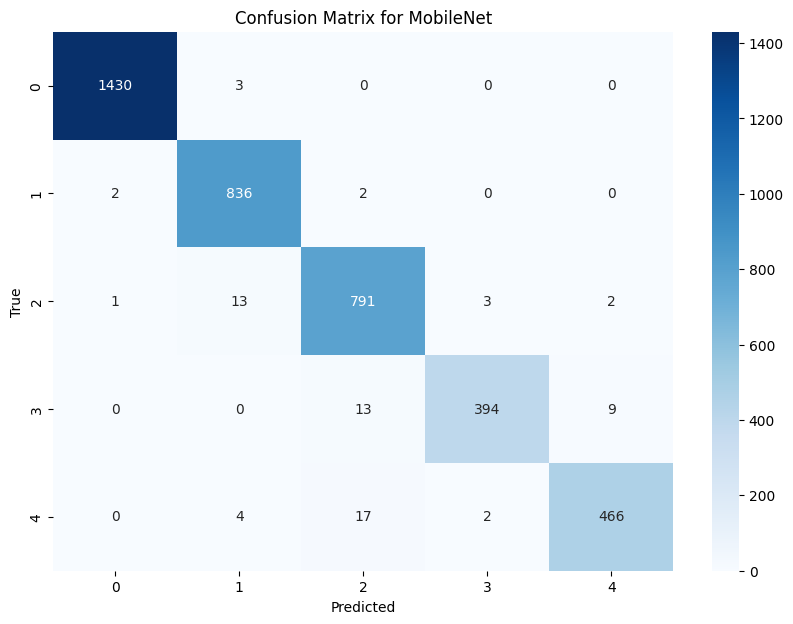

In [21]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"MobileNet - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MobileNet')
plt.show()

In [7]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Xception - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Xception')
plt.show()

Epoch 1/10
78/92 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6785 - loss: 0.9716

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"ResNet50V2 - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ResNet50V2')
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"DenseNet201 - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DenseNet201')
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet169

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"DenseNet169 - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DenseNet169')
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"InceptionV3 - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for InceptionV3')
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(base_model)
model = compile_model(model)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"InceptionResNetV2 - Val Loss: {val_loss}, Val Accuracy: {val_acc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for InceptionResNetV2')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def ensemble_predictions(models, X):
    predictions = [model.predict(X) for model in models]
    predictions = np.mean(predictions, axis=0)
    return np.argmax(predictions, axis=1)

def evaluate_ensemble(X_val, y_val):
    y_pred = ensemble_predictions(models.values(), X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    return accuracy, precision, recall, f1

ensemble_results = evaluate_ensemble(X_val, y_val)
print(f"Ensemble Model - Accuracy: {ensemble_results[0]}, Precision: {ensemble_results[1]}, Recall: {ensemble_results[2]}, F1 Score: {ensemble_results[3]}")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

def fit_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=(X_val, y_val),
                        epochs=30,
                        callbacks=[early_stopping, reduce_lr])
    return history

for name, model in models.items():
    print(f"Training and Evaluating {name} with Augmentation and Regularization")
    fit_and_evaluate_model(model, X_train, y_train, X_val, y_val)
